In [1]:
!pip install ipynb

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [5/50] Batch 391/391                   Loss Discriminator: 0.571, loss Generator: 1.513 FID:337.311 

Epoch [10/50] Batch 391/391                   Loss Discriminator: 0.627, loss Generator: 1.062 FID:207.437 

Epoch [15/50] Batch 391/391                   Loss Discriminator: 0.654, loss Generator: 1.347 FID:188.785 

Epoch [20/50] Batch 391/391                   Loss Discriminator: 0.667, loss Generator: 0.796 FID:196.859 

Epoch [25/50] Batch 391/391                   Loss Discriminator: 0.594, loss Generator: 1.143 FID:181.027 

Epoch [30/50] Batch 391/391                   Loss Discriminator: 0.578, loss Generator: 1.046 FID:180.857 

Epoch [35/50] Batch 391/391                   Loss Discriminator: 0.546, loss Generator: 1.723 FID:180.692 

Epoch [40/50] Batch 391/391                   Loss Discriminator: 0.514, loss Generator: 1.239 FID:182.590 

Epoch [45/50] Batch 391/391                   Loss Discriminator: 0.468, loss Generator: 1.298 FID:179.841 

Epoch [50/50] Batch

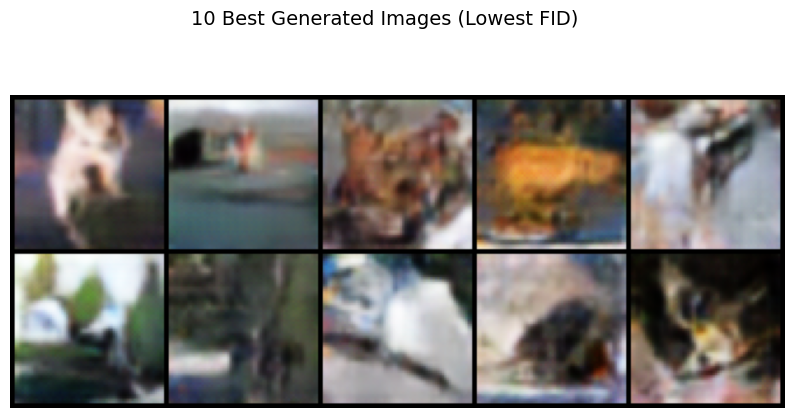

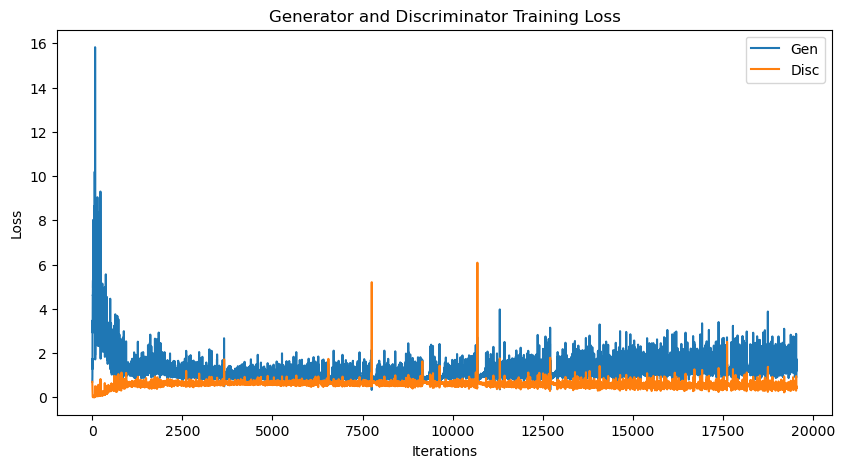

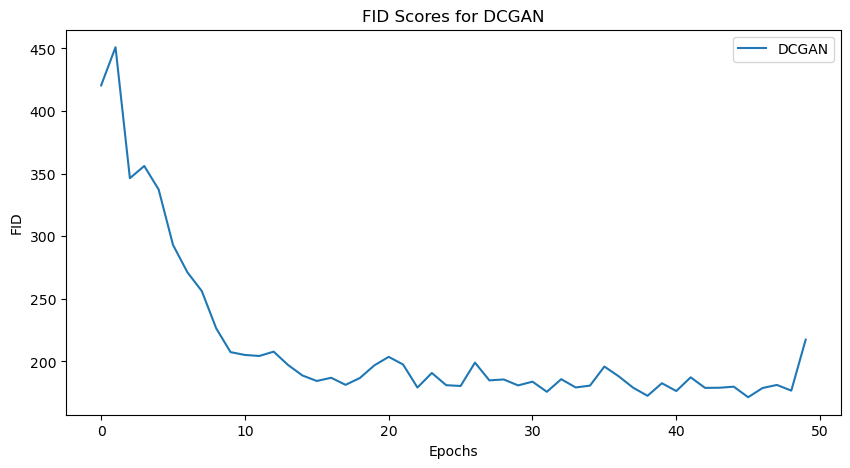

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
import os
from ipynb.fs.full.FID import calculate_fretchet


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
batch_size = 128
image_size = 64
channels_img = 3  
noise_dim = 100
max_epochs = 50
disc_features = 64 
gen_features = 64 
beta = 0.5

dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)



class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d * 2, 4, 2, 1),     
            self.block(features_d * 2, features_d * 4, 4, 2, 1),
            self.block(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,), 
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)
    
   

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(channels_noise, features_g * 16, 4, 1, 0), 
            self.block(features_g * 16, features_g * 8, 4, 2, 1), 
            self.block(features_g * 8, features_g * 4, 4, 2, 1), 
            self.block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)
    

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

            
gen = Generator(noise_dim, channels_img, gen_features).to(device)
disc = Discriminator(channels_img, disc_features).to(device)
initialize_weights(gen)
initialize_weights(disc)
optimGenerator = optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
step = 0




#training block
gen.train()
disc.train()
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
best_fid = float('inf')
iters = 0


for epoch in range(max_epochs):
    epoch = epoch+1

    for batch_idx, data in enumerate(dataloader,0):
        real = data[0].to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = gen(noise)

        #Discriminator Training
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        #Train Generator Training
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == max_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    
    fretchet_dist=calculate_fretchet(real,fake)
    FID_list.append(fretchet_dist)
    
    if fretchet_dist < best_fid:
        best_fid = fretchet_dist
        best_fake = gen(fixed_noise).detach().cpu()

    if epoch%5 == 0:
        print( f'\nEpoch [{epoch}/{max_epochs}] Batch {batch_idx+1}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f} ')      

# Display the 10 best generated images in a grid
plt.figure(figsize=(10, 5))
plt.suptitle("10 Best Generated Images (Lowest FID)", fontsize=14)
grid = utils.make_grid(best_fake[:10], nrow=5, normalize=True)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('DCGAN_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=(10,5))
plt.title("FID Scores for DCGAN")
plt.plot(FID_list,label="DCGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('DCGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

np.save('DC_FID', FID_list)

